In [27]:
!pip install SimpleITK
!pip install opencv-python
!pip install segmentation-models-pytorch
!pip install monai
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 436.9 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 25.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.8 MB/s eta 0:00:0000:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depende

In [1]:
import os
import cv2
import glob
import torch
import monai
import random
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import SimpleITK as sitk

torch.manual_seed(1024)
np.random.seed(1024)
device = torch.device(
    "cuda:1"
    if torch.cuda.is_available()
    else
    "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda:1 device


In [3]:
# !gunzip -r ./Dataset/ACDC/database/training/

In [4]:
def convert_to_npy(source_path):
    """
    Convert the nii file to npz, reduce RAM cost at the creation of dataset

    Args:
        source_path: file path to nii files

    Returns:
    """
    patient_directories = glob.glob(os.path.join(source_path, 'patient*'))
    for patient_dir in patient_directories:
        gt_image_paths = glob.glob(os.path.join(patient_dir, '*_gt.nii'))
        for gt_image_path in gt_image_paths:
            prefix = gt_image_path[:-7]
            image_path = prefix + ".nii"
            gt_image_array = sitk.GetArrayFromImage(sitk.ReadImage(gt_image_path))
            image_array = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
            for i, image in enumerate(image_array):
                np.save(prefix + '_slice' + str(i) + '.npy', image)
            for i, gt_image in enumerate(gt_image_array):
                np.save(prefix + '_slice' + str(i) + '_gt.npy', gt_image)

In [5]:
#convert_to_npy('./Dataset/ACDC/database/training')

NiftiImageIO (0x618a370): ./Dataset/ACDC/database/training/patient032/patient032_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x618a370): ./Dataset/ACDC/database/training/patient032/patient032_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x62316d0): ./Dataset/ACDC/database/training/patient032/patient032_frame01.nii has unexpected scales in sform

NiftiImageIO (0x62316d0): ./Dataset/ACDC/database/training/patient032/patient032_frame01.nii has unexpected scales in sform

NiftiImageIO (0x618a370): ./Dataset/ACDC/database/training/patient032/patient032_frame12_gt.nii has unexpected scales in sform

NiftiImageIO (0x618a370): ./Dataset/ACDC/database/training/patient032/patient032_frame12_gt.nii has unexpected scales in sform

NiftiImageIO (0x62316d0): ./Dataset/ACDC/database/training/patient032/patient032_frame12.nii has unexpected scales in sform

NiftiImageIO (0x62316d0): ./Dataset/ACDC/database/training/patient032/patient032_frame12.nii has unexpected scale

In [3]:
class SegDataset(Dataset):
    def __init__(self, data_root, transform=None, target_transform=None, train=True):
        self.data_root = data_root
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.gt_files_path = []
        # find all patient directories
        patient_directories = glob.glob(os.path.join(self.data_root, 'patient*'))
        # find all files with the suffix _gt.npy
        for patient_directory in patient_directories:
            per_patient_file_path = glob.glob(os.path.join(patient_directory, '*_gt.npy'))
            for path in per_patient_file_path:
                self.gt_files_path.append(path)
        
    def __len__(self):
        return len(self.gt_files_path)
    
    def __getitem__(self, index):
        gt_image_path = self.gt_files_path[index]
        image_path = gt_image_path[:-7] + ".npy"
        image = np.load(image_path)
        gt_image = np.load(gt_image_path)
        image = torch.tensor(image[None,:,:]).float()
        gt_image = torch.tensor(gt_image).long()
            
        # Convert the ground truth label to one-hot encoding
        one_hot_label = torch.nn.functional.one_hot(gt_image, num_classes=4)

        # Transpose the tensor to have dimensions (C, H, W)
        one_hot_label = one_hot_label.permute(2, 0, 1)

        # Remove the background channel (dimension 0)
        one_hot_label = one_hot_label[1:, :, :]
        
        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        if self.transform is not None:
            image = self.transform(image)
            
        random.seed(seed) # apply this seed to target tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        if self.target_transform is not None:
            target = self.target_transform(one_hot_label)
        
        return image, target
        
#         transform = transforms.Resize([224, 224])
        
#         return transform(image), transform(one_hot_label)

1902
img.shape=torch.Size([8, 1, 224, 224]), gt.shape=torch.Size([8, 3, 224, 224])


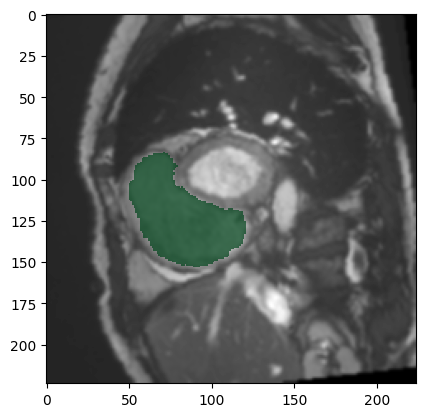

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop([224, 224]),
    transforms.GaussianBlur(3)
])

target_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop([224, 224])
])

dataset = SegDataset(data_root = './database/training', 
                     transform = transform, 
                     target_transform = target_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
print(len(dataset))
for img, gt in dataloader:
    # img: (B, 256, 64, 64), {: (B, 1, 256, 256)
    print(f"{img.shape=}, {gt.shape=}")
    test_img = img[0][0]
    test_gt = gt[0].numpy()
    plt.figure()
    # f, axarr = plt.subplots(1,4) 
    plt.imshow(test_img, 'gray')
    overlay_mask = np.ma.masked_where(test_gt[0] == 0, test_img)
    plt.imshow(overlay_mask, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
    # axarr[0].imshow(test_img, cmap = 'gray')
    # axarr[1].imshow(test_gt[0], cmap = 'gray')
    # axarr[2].imshow(test_gt[1], cmap = 'gray')
    # axarr[3].imshow(test_gt[2], cmap = 'gray')
    plt.show()
    break

In [5]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

preprocess_input = get_preprocessing_fn('resnet50', pretrained='imagenet')

model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [6]:
# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
#%% train
num_epochs = 20
losses = []
best_loss = 1e10
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (img, gt) in enumerate(tqdm(dataloader)):
        img = img.to(device)
        mask = model(img)
        loss = seg_loss(mask, gt.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), './model/unet-test/model_best.pth')

  0%|          | 0/238 [00:00<?, ?it/s]/home/jovyan/.local/lib/python3.8/site-packages/monai/losses/dice.py:708: UserWarning: Multichannel targets are not supported in this older Pytorch version 1.8.0+cu111. Using argmax (as a workaround) to convert target to a single channel.
  warnings.warn(
100%|██████████| 238/238 [01:11<00:00,  3.34it/s]


EPOCH: 0, Loss: 1.0008147326199817


100%|██████████| 238/238 [01:00<00:00,  3.93it/s]


EPOCH: 1, Loss: 0.6383615893150684


100%|██████████| 238/238 [00:59<00:00,  3.97it/s]


EPOCH: 2, Loss: 0.545420778703086


100%|██████████| 238/238 [01:00<00:00,  3.96it/s]


EPOCH: 3, Loss: 0.524144567140547


100%|██████████| 238/238 [00:59<00:00,  3.97it/s]


EPOCH: 4, Loss: 0.5117039374912842


100%|██████████| 238/238 [01:02<00:00,  3.81it/s]


EPOCH: 5, Loss: 0.49849318804117193


 58%|█████▊    | 138/238 [00:36<00:25,  3.86it/s]